# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

import sys
import numpy as np
#sys.path.insert(0, './src')


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

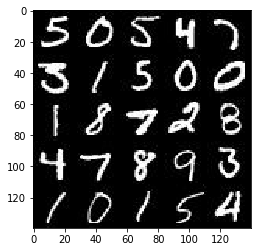

In [2]:
show_n_images = 25

### needed to hack this to make it work; I think this is a matplotlib version issue

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

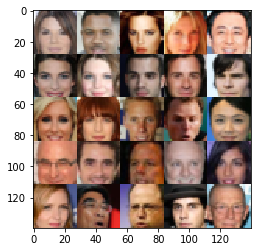

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    inputs_z = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/usr/lo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        layer1 = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=2, padding = 'same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(layer1, alpha*layer1)
        relu1 = tf.nn.dropout(relu1, 0.9)
              
        layer2 = tf.layers.conv2d(relu1, filters=128, kernel_size=5, strides=2, padding = 'same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(layer2, training=True)
        relu2 = tf.maximum(bn2, alpha*bn2)
        relu2 = tf.nn.dropout(relu2, 0.9)
        
        layer3 = tf.layers.conv2d(relu2, filters=256, kernel_size=5, strides=2, padding = 'same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(layer3, training=True)
        relu3 = tf.maximum(bn3, alpha*bn3)
        relu3 = tf.nn.dropout(relu3, 0.9)
        
        flatten = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flatten,1)
        out = tf.sigmoid(logits)
        
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse = (not is_train)):
        
        #added droout at 90% as per suggestion at https://github.com/soumith/ganhacks
        
        layer1 = tf.layers.dense(z, 7*7*256, kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer1 = tf.reshape(layer1, (-1,7,7,256))
        layer1 = tf.layers.batch_normalization(layer1, training = is_train)
        layer1 = tf.maximum(layer1, alpha*layer1)
        layer1 = tf.nn.dropout(layer1, 0.9)
        
        layer2 = tf.layers.conv2d_transpose(layer1,128,5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer2 = tf.layers.batch_normalization(layer2, training = is_train)
        layer2 = tf.maximum(layer2, alpha*layer2)
        layer2 = tf.nn.dropout(layer2, 0.9)

        layer3 = tf.layers.conv2d_transpose(layer2,64,5, strides=2, padding = 'same')
        layer3 = tf.layers.batch_normalization(layer3, training = is_train)
        layer3 = tf.maximum(layer3, alpha*layer3)
        layer3 = tf.nn.dropout(layer3, 0.9)
        
        logits = tf.layers.conv2d_transpose(layer3, out_channel_dim, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
       
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    gen_img = generator(input_z, out_channel_dim)
    disc_model_real, disc_logits_real = discriminator(input_real)
    disc_model_fake, disc_logits_fake = discriminator(gen_img, reuse = True)
    
    smooth = 0.9
    
    d_loss_real = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits = disc_logits_real,labels = tf.ones_like(disc_model_real)*smooth))
    
    d_loss_fake = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits = disc_model_fake,labels = tf.zeros_like(disc_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits = disc_model_fake,labels = tf.ones_like(disc_model_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    trainable_vars = tf.trainable_variables()
    disc_vars = [var for var in trainable_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in trainable_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=disc_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)

    return d_train_opt, g_train_opt 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    losses = []
    steps = 0
    
    _, image_width, image_height, image_channels = data_shape
    inputs_real, inputs_z, learning_rate_pl = model_inputs(image_width,image_height,image_channels,z_dim)
    
    d_loss, g_loss = model_loss(inputs_real, inputs_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    n_images = batch_size
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2.0
                
                _ = sess.run(d_opt, feed_dict={inputs_real:batch_images,inputs_z:batch_z,learning_rate_pl:learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_real:batch_images,inputs_z:batch_z,learning_rate_pl:learning_rate})
                
                if steps % 10 == 0 :
                    train_loss_d = d_loss.eval({inputs_real:batch_images,inputs_z:batch_z})
                    train_loss_g = g_loss.eval({inputs_z:batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
                
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess,25,inputs_z,image_channels,data_image_mode)
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [62]:
### Could not get this to work at all due to matplotlib issues

batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, celeba_dataset.image_mode)

Epoch 1/2... Discriminator Loss: 1.8514... Generator Loss: 0.3141
Epoch 1/2... Discriminator Loss: 1.1190... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0260... Generator Loss: 0.6930
Epoch 1/2... Discriminator Loss: 1.0252... Generator Loss: 0.6929


KeyboardInterrupt: 

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 0.5984
Epoch 1/1... Discriminator Loss: 1.1677... Generator Loss: 0.6038
Epoch 1/1... Discriminator Loss: 1.0949... Generator Loss: 0.6191
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.6049
Epoch 1/1... Discriminator Loss: 1.0636... Generator Loss: 0.6783
Epoch 1/1... Discriminator Loss: 1.2595... Generator Loss: 0.5995
Epoch 1/1... Discriminator Loss: 1.1115... Generator Loss: 0.6383
Epoch 1/1... Discriminator Loss: 1.0910... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.0571... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 0.6702


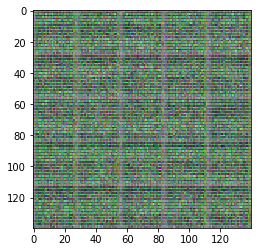

Epoch 1/1... Discriminator Loss: 1.0758... Generator Loss: 0.6763
Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 1.0546... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.0562... Generator Loss: 0.6868
Epoch 1/1... Discriminator Loss: 1.0455... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.0610... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.5203
Epoch 1/1... Discriminator Loss: 1.1131... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.5781


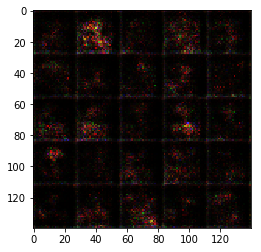

Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 0.6160
Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 0.5964
Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 0.6206
Epoch 1/1... Discriminator Loss: 1.4864... Generator Loss: 0.4203
Epoch 1/1... Discriminator Loss: 1.1354... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 1.2190... Generator Loss: 0.5766
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.1036... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 0.6084
Epoch 1/1... Discriminator Loss: 1.5113... Generator Loss: 0.4523


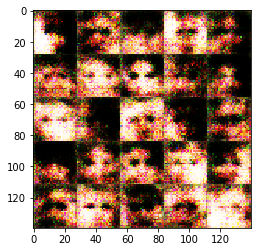

Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.0940... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.1425... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.5734
Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.0604... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.0637... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.0788... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 0.6811


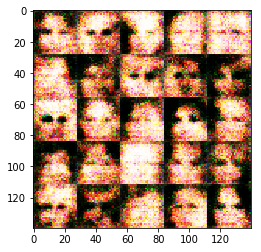

Epoch 1/1... Discriminator Loss: 1.0718... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 1.0533... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 0.6111
Epoch 1/1... Discriminator Loss: 1.0987... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.0539... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.0310... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.0467... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.0603... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.0414... Generator Loss: 0.6893


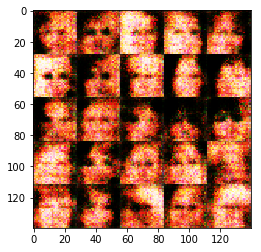

Epoch 1/1... Discriminator Loss: 1.0731... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 0.6116
Epoch 1/1... Discriminator Loss: 1.1297... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.0414... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 1.0432... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.0544... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.0471... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.1717... Generator Loss: 0.6137
Epoch 1/1... Discriminator Loss: 1.0789... Generator Loss: 0.6550


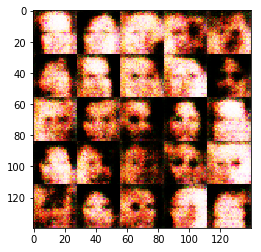

Epoch 1/1... Discriminator Loss: 1.0327... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.0686... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.0449... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 1.0421... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.0416... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.0389... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.0314... Generator Loss: 0.6888
Epoch 1/1... Discriminator Loss: 1.0398... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 1.0479... Generator Loss: 0.6904


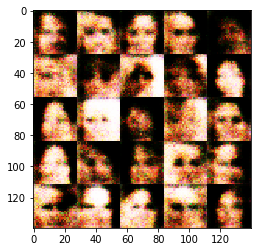

Epoch 1/1... Discriminator Loss: 1.0542... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.0441... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.0508... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.0425... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 0.6239
Epoch 1/1... Discriminator Loss: 1.0440... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.0413... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.0604... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.0487... Generator Loss: 0.6748


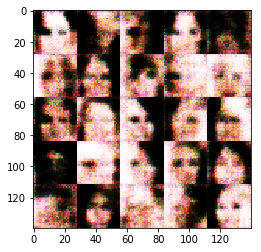

Epoch 1/1... Discriminator Loss: 1.0534... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.0473... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.0438... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 1.0613... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.0498... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.0650... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.0340... Generator Loss: 0.6891
Epoch 1/1... Discriminator Loss: 1.0511... Generator Loss: 0.6865


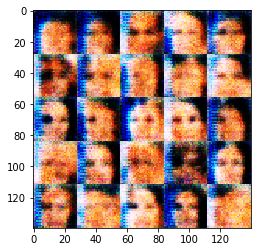

Epoch 1/1... Discriminator Loss: 1.0427... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 1.0448... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.0347... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.0490... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.5445
Epoch 1/1... Discriminator Loss: 1.0607... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.1025... Generator Loss: 0.6299
Epoch 1/1... Discriminator Loss: 1.0419... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.0791... Generator Loss: 0.6632
Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.6258


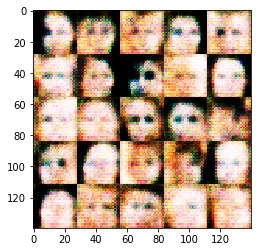

Epoch 1/1... Discriminator Loss: 1.0438... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 1.0620... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 0.5998
Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.0755... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.0482... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.0356... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.1201... Generator Loss: 0.6160
Epoch 1/1... Discriminator Loss: 1.0368... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.1020... Generator Loss: 0.6469


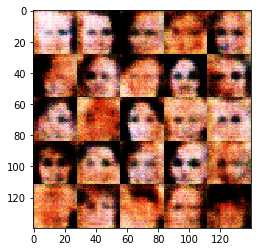

Epoch 1/1... Discriminator Loss: 1.0490... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.0374... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.0478... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.0401... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.0379... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.0378... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 1.0397... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 0.6409
Epoch 1/1... Discriminator Loss: 1.0751... Generator Loss: 0.6523


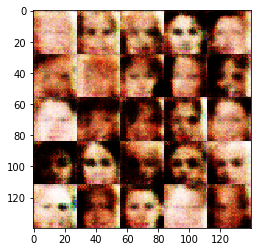

Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.0398... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 0.5155
Epoch 1/1... Discriminator Loss: 1.5161... Generator Loss: 0.4106
Epoch 1/1... Discriminator Loss: 1.0752... Generator Loss: 0.6830
Epoch 1/1... Discriminator Loss: 1.1005... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 1.0460... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1040... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.0402... Generator Loss: 0.6931


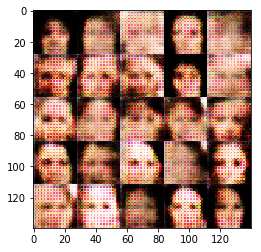

Epoch 1/1... Discriminator Loss: 1.0296... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.0275... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.0349... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.0290... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.0234... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.0259... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.2410... Generator Loss: 0.5058
Epoch 1/1... Discriminator Loss: 1.0444... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.0865... Generator Loss: 0.6868


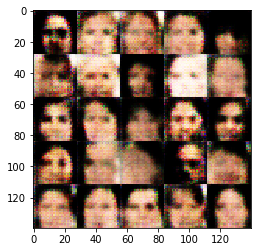

Epoch 1/1... Discriminator Loss: 1.2260... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 0.6165
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 0.6095
Epoch 1/1... Discriminator Loss: 1.0913... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.8207... Generator Loss: 0.3419
Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 0.6196
Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.4502
Epoch 1/1... Discriminator Loss: 1.1003... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 0.6192


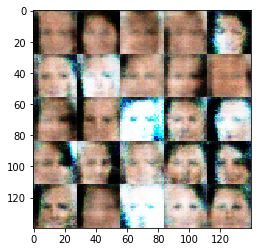

Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 0.5780
Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 0.6216
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 0.6106
Epoch 1/1... Discriminator Loss: 1.2503... Generator Loss: 0.4962
Epoch 1/1... Discriminator Loss: 1.2121... Generator Loss: 0.5805
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.4848
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 0.5423
Epoch 1/1... Discriminator Loss: 1.5625... Generator Loss: 0.3652
Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 0.6674


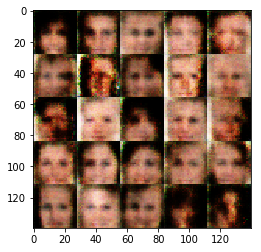

Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.4915
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 1.1934... Generator Loss: 0.5542
Epoch 1/1... Discriminator Loss: 1.1874... Generator Loss: 0.5658
Epoch 1/1... Discriminator Loss: 1.1941... Generator Loss: 0.5640
Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 0.6285
Epoch 1/1... Discriminator Loss: 1.1738... Generator Loss: 0.5921
Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 0.6443
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.5179
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.4334


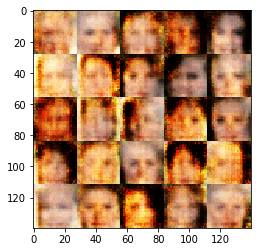

Epoch 1/1... Discriminator Loss: 1.5108... Generator Loss: 0.4291
Epoch 1/1... Discriminator Loss: 1.0956... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 0.6352
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.4504
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 0.5667
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.4796
Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 0.4072
Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 0.5510
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.5892


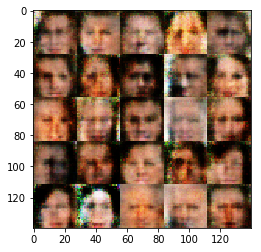

Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.5312
Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 0.5833
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.4797
Epoch 1/1... Discriminator Loss: 1.6387... Generator Loss: 0.3236
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.4580
Epoch 1/1... Discriminator Loss: 1.4861... Generator Loss: 0.3790
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.4643
Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 0.5019
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.5035
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.4195


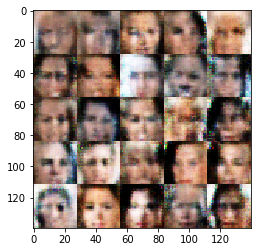

Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.4141
Epoch 1/1... Discriminator Loss: 1.5674... Generator Loss: 0.3609
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.4917
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.4713
Epoch 1/1... Discriminator Loss: 1.5463... Generator Loss: 0.4834
Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 0.4232
Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.5161
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.4299
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.4481
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.4853


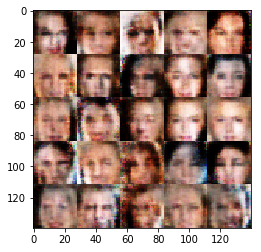

Epoch 1/1... Discriminator Loss: 1.5601... Generator Loss: 0.3501
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.4000
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.5645
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.4501
Epoch 1/1... Discriminator Loss: 1.5596... Generator Loss: 0.3402
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.5302
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.4106
Epoch 1/1... Discriminator Loss: 1.5011... Generator Loss: 0.3893
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.5224
Epoch 1/1... Discriminator Loss: 1.4801... Generator Loss: 0.3775


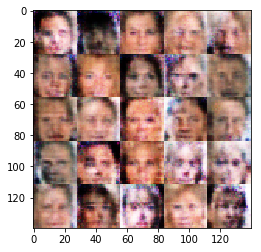

Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.4330
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.5458
Epoch 1/1... Discriminator Loss: 1.5102... Generator Loss: 0.3969
Epoch 1/1... Discriminator Loss: 1.5531... Generator Loss: 0.4648
Epoch 1/1... Discriminator Loss: 1.5016... Generator Loss: 0.4162
Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 0.4838
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.5262
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.4094
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.4602
Epoch 1/1... Discriminator Loss: 1.6333... Generator Loss: 0.3454


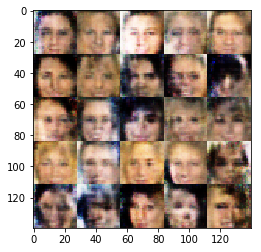

Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.4441
Epoch 1/1... Discriminator Loss: 1.5204... Generator Loss: 0.3780
Epoch 1/1... Discriminator Loss: 1.5309... Generator Loss: 0.3723
Epoch 1/1... Discriminator Loss: 1.4750... Generator Loss: 0.3896
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.4225
Epoch 1/1... Discriminator Loss: 1.5236... Generator Loss: 0.3960
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.5062
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.4312
Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 0.4431
Epoch 1/1... Discriminator Loss: 1.5110... Generator Loss: 0.3819


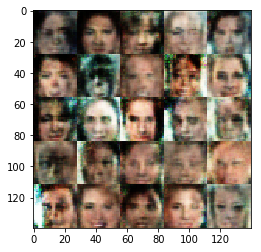

Epoch 1/1... Discriminator Loss: 1.4878... Generator Loss: 0.4098
Epoch 1/1... Discriminator Loss: 1.5439... Generator Loss: 0.3568
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.4089
Epoch 1/1... Discriminator Loss: 1.5373... Generator Loss: 0.4403
Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.4294
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.4028
Epoch 1/1... Discriminator Loss: 1.5127... Generator Loss: 0.3723
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.4762
Epoch 1/1... Discriminator Loss: 1.4846... Generator Loss: 0.3992
Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.4557


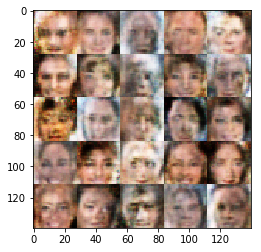

Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.4107
Epoch 1/1... Discriminator Loss: 1.5535... Generator Loss: 0.3726
Epoch 1/1... Discriminator Loss: 1.5245... Generator Loss: 0.4083
Epoch 1/1... Discriminator Loss: 1.5174... Generator Loss: 0.3751
Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.4569
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.4455
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.4235
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.4555
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.4829
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.4280


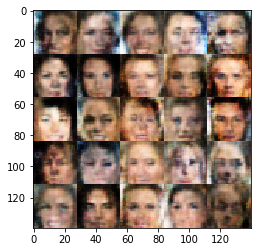

Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.3686
Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.4340
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.4657
Epoch 1/1... Discriminator Loss: 1.5046... Generator Loss: 0.3758
Epoch 1/1... Discriminator Loss: 1.4817... Generator Loss: 0.3991
Epoch 1/1... Discriminator Loss: 1.5189... Generator Loss: 0.3897
Epoch 1/1... Discriminator Loss: 1.5118... Generator Loss: 0.4062
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.4287
Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.4365
Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 0.4032


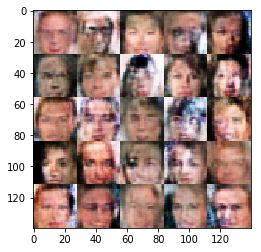

Epoch 1/1... Discriminator Loss: 1.4875... Generator Loss: 0.4051
Epoch 1/1... Discriminator Loss: 1.5156... Generator Loss: 0.3850
Epoch 1/1... Discriminator Loss: 1.4922... Generator Loss: 0.4061
Epoch 1/1... Discriminator Loss: 1.5078... Generator Loss: 0.3872
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.4184
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.4104
Epoch 1/1... Discriminator Loss: 1.5101... Generator Loss: 0.3830
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.4303
Epoch 1/1... Discriminator Loss: 1.4964... Generator Loss: 0.3899
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.4092


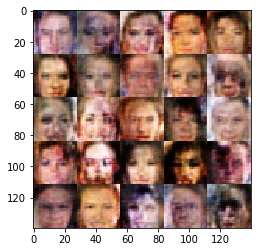

Epoch 1/1... Discriminator Loss: 1.5065... Generator Loss: 0.4005
Epoch 1/1... Discriminator Loss: 1.5079... Generator Loss: 0.3612
Epoch 1/1... Discriminator Loss: 1.4951... Generator Loss: 0.3891
Epoch 1/1... Discriminator Loss: 1.5208... Generator Loss: 0.3762
Epoch 1/1... Discriminator Loss: 1.4735... Generator Loss: 0.4030
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.5001
Epoch 1/1... Discriminator Loss: 1.5341... Generator Loss: 0.3625
Epoch 1/1... Discriminator Loss: 1.5145... Generator Loss: 0.3768
Epoch 1/1... Discriminator Loss: 1.4984... Generator Loss: 0.4007
Epoch 1/1... Discriminator Loss: 1.4803... Generator Loss: 0.4120


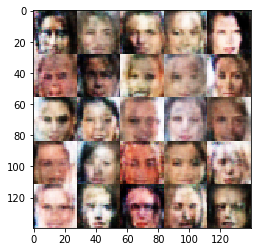

Epoch 1/1... Discriminator Loss: 1.5041... Generator Loss: 0.3753
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.4006
Epoch 1/1... Discriminator Loss: 1.4957... Generator Loss: 0.4019
Epoch 1/1... Discriminator Loss: 1.5260... Generator Loss: 0.3689
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.4071
Epoch 1/1... Discriminator Loss: 1.4976... Generator Loss: 0.3854
Epoch 1/1... Discriminator Loss: 1.4849... Generator Loss: 0.4005
Epoch 1/1... Discriminator Loss: 1.5015... Generator Loss: 0.3736
Epoch 1/1... Discriminator Loss: 1.4778... Generator Loss: 0.4147
Epoch 1/1... Discriminator Loss: 1.5032... Generator Loss: 0.3842


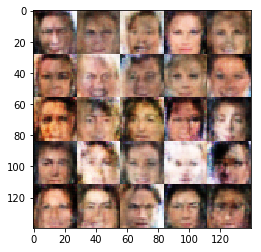

Epoch 1/1... Discriminator Loss: 1.4856... Generator Loss: 0.4023
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.4611
Epoch 1/1... Discriminator Loss: 1.5057... Generator Loss: 0.3785
Epoch 1/1... Discriminator Loss: 1.5018... Generator Loss: 0.3866
Epoch 1/1... Discriminator Loss: 1.5509... Generator Loss: 0.3680
Epoch 1/1... Discriminator Loss: 1.4853... Generator Loss: 0.3853
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.4591
Epoch 1/1... Discriminator Loss: 1.5004... Generator Loss: 0.3740
Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 0.4132
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.4360


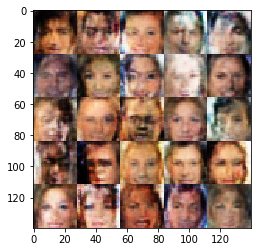

Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.4007
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.4077
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.4108
Epoch 1/1... Discriminator Loss: 1.5386... Generator Loss: 0.3690
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.4339
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.3716
Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.3759
Epoch 1/1... Discriminator Loss: 1.5027... Generator Loss: 0.4143
Epoch 1/1... Discriminator Loss: 1.4988... Generator Loss: 0.3966
Epoch 1/1... Discriminator Loss: 1.5063... Generator Loss: 0.3878


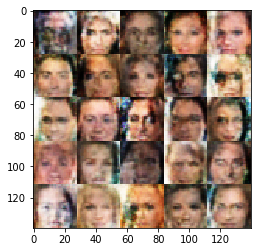

Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.4259
Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.3952
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.4748
Epoch 1/1... Discriminator Loss: 1.5481... Generator Loss: 0.3667
Epoch 1/1... Discriminator Loss: 1.5141... Generator Loss: 0.3643
Epoch 1/1... Discriminator Loss: 1.5251... Generator Loss: 0.3690
Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.3895
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.4075
Epoch 1/1... Discriminator Loss: 1.5240... Generator Loss: 0.3811
Epoch 1/1... Discriminator Loss: 1.4870... Generator Loss: 0.4139


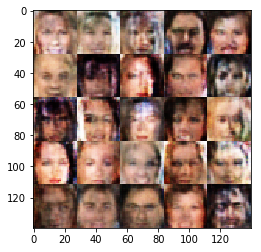

Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.4201
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.4100
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.3921
Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.3864
Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.4148
Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.4567
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.4439
Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 0.3865
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.4068
Epoch 1/1... Discriminator Loss: 1.4992... Generator Loss: 0.4351


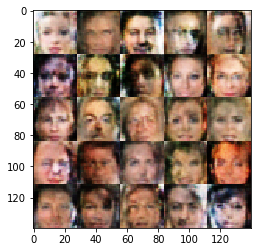

Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.3832
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.3998
Epoch 1/1... Discriminator Loss: 1.4927... Generator Loss: 0.4114
Epoch 1/1... Discriminator Loss: 1.4940... Generator Loss: 0.3875
Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.4203
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.4055
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.4001
Epoch 1/1... Discriminator Loss: 1.5374... Generator Loss: 0.3851
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.4188
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.4463


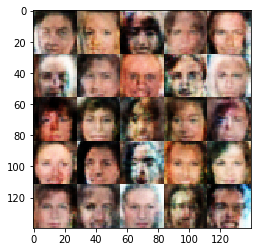

Epoch 1/1... Discriminator Loss: 1.5031... Generator Loss: 0.3755
Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 0.4170
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.4448
Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.4247
Epoch 1/1... Discriminator Loss: 1.6187... Generator Loss: 0.3403
Epoch 1/1... Discriminator Loss: 1.5534... Generator Loss: 0.3581
Epoch 1/1... Discriminator Loss: 1.5048... Generator Loss: 0.3911
Epoch 1/1... Discriminator Loss: 1.4694... Generator Loss: 0.4041
Epoch 1/1... Discriminator Loss: 1.4844... Generator Loss: 0.4142
Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.3917


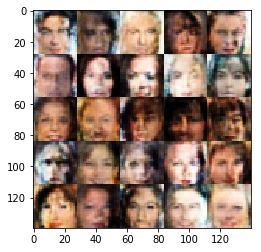

Epoch 1/1... Discriminator Loss: 1.5366... Generator Loss: 0.3868
Epoch 1/1... Discriminator Loss: 1.4905... Generator Loss: 0.4169
Epoch 1/1... Discriminator Loss: 1.5371... Generator Loss: 0.3753
Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.4124
Epoch 1/1... Discriminator Loss: 1.5285... Generator Loss: 0.3916
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.4076
Epoch 1/1... Discriminator Loss: 1.4995... Generator Loss: 0.3982
Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.3806
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.4220
Epoch 1/1... Discriminator Loss: 1.5271... Generator Loss: 0.3664


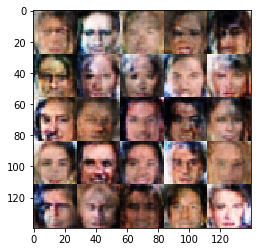

Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.4040
Epoch 1/1... Discriminator Loss: 1.5059... Generator Loss: 0.3765
Epoch 1/1... Discriminator Loss: 1.4759... Generator Loss: 0.3963
Epoch 1/1... Discriminator Loss: 1.4917... Generator Loss: 0.3951
Epoch 1/1... Discriminator Loss: 1.4807... Generator Loss: 0.3975
Epoch 1/1... Discriminator Loss: 1.4780... Generator Loss: 0.4050
Epoch 1/1... Discriminator Loss: 1.5106... Generator Loss: 0.3792
Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 0.4312
Epoch 1/1... Discriminator Loss: 1.5548... Generator Loss: 0.3670
Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.4586


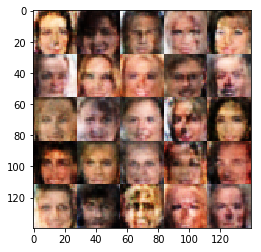

Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.4569
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.4252
Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.3957
Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.4010
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.4857
Epoch 1/1... Discriminator Loss: 1.5083... Generator Loss: 0.3784
Epoch 1/1... Discriminator Loss: 1.5145... Generator Loss: 0.3833
Epoch 1/1... Discriminator Loss: 1.4947... Generator Loss: 0.4146
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.4140
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.4248


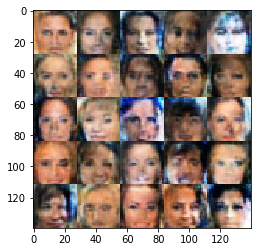

Epoch 1/1... Discriminator Loss: 1.4962... Generator Loss: 0.3933
Epoch 1/1... Discriminator Loss: 1.5323... Generator Loss: 0.3720
Epoch 1/1... Discriminator Loss: 1.5640... Generator Loss: 0.3581
Epoch 1/1... Discriminator Loss: 1.5298... Generator Loss: 0.3774
Epoch 1/1... Discriminator Loss: 1.4786... Generator Loss: 0.3855
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.4041
Epoch 1/1... Discriminator Loss: 1.4992... Generator Loss: 0.3767
Epoch 1/1... Discriminator Loss: 1.5221... Generator Loss: 0.3685
Epoch 1/1... Discriminator Loss: 1.5084... Generator Loss: 0.3779
Epoch 1/1... Discriminator Loss: 1.4903... Generator Loss: 0.3875


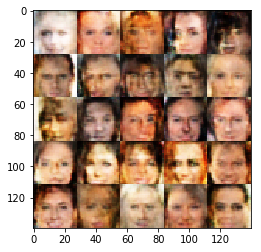

Epoch 1/1... Discriminator Loss: 1.4913... Generator Loss: 0.4048
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.4109
Epoch 1/1... Discriminator Loss: 1.5069... Generator Loss: 0.3760
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.4021
Epoch 1/1... Discriminator Loss: 1.5014... Generator Loss: 0.3907
Epoch 1/1... Discriminator Loss: 1.5456... Generator Loss: 0.3556
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.3982
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.4354
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.4099
Epoch 1/1... Discriminator Loss: 1.5102... Generator Loss: 0.4053


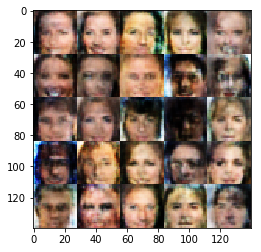

Epoch 1/1... Discriminator Loss: 1.4807... Generator Loss: 0.3970
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.4550
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.4063
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.4165
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.4505
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.4035
Epoch 1/1... Discriminator Loss: 1.5249... Generator Loss: 0.4015
Epoch 1/1... Discriminator Loss: 1.5055... Generator Loss: 0.3667
Epoch 1/1... Discriminator Loss: 1.5272... Generator Loss: 0.3597
Epoch 1/1... Discriminator Loss: 1.4942... Generator Loss: 0.4117


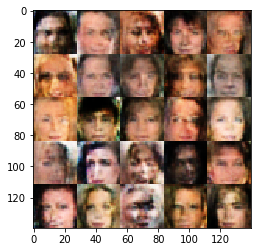

Epoch 1/1... Discriminator Loss: 1.4885... Generator Loss: 0.3872
Epoch 1/1... Discriminator Loss: 1.5372... Generator Loss: 0.3805
Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.4387
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.3842
Epoch 1/1... Discriminator Loss: 1.4849... Generator Loss: 0.3911
Epoch 1/1... Discriminator Loss: 1.5181... Generator Loss: 0.3690
Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.4133
Epoch 1/1... Discriminator Loss: 1.5258... Generator Loss: 0.3696
Epoch 1/1... Discriminator Loss: 1.5041... Generator Loss: 0.3809
Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 0.4652


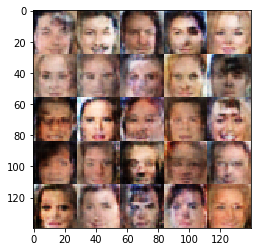

Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.4277
Epoch 1/1... Discriminator Loss: 1.5583... Generator Loss: 0.3557
Epoch 1/1... Discriminator Loss: 1.5256... Generator Loss: 0.3740
Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 0.4012
Epoch 1/1... Discriminator Loss: 1.5075... Generator Loss: 0.4042
Epoch 1/1... Discriminator Loss: 1.5158... Generator Loss: 0.3825
Epoch 1/1... Discriminator Loss: 1.5417... Generator Loss: 0.3672
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.3975
Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 0.3915
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.4918


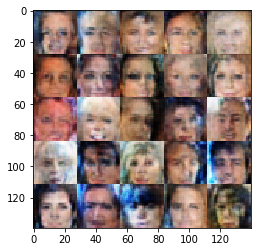

Epoch 1/1... Discriminator Loss: 1.4921... Generator Loss: 0.4056
Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.3970
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.4107
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.4552
Epoch 1/1... Discriminator Loss: 1.5263... Generator Loss: 0.3601
Epoch 1/1... Discriminator Loss: 1.5082... Generator Loss: 0.3816
Epoch 1/1... Discriminator Loss: 1.4796... Generator Loss: 0.3775
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.4188
Epoch 1/1... Discriminator Loss: 1.5419... Generator Loss: 0.3782
Epoch 1/1... Discriminator Loss: 1.4909... Generator Loss: 0.4109


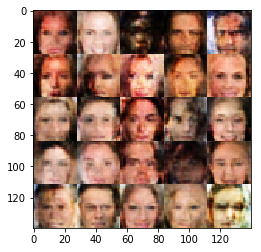

Epoch 1/1... Discriminator Loss: 1.4470... Generator Loss: 0.4453
Epoch 1/1... Discriminator Loss: 1.5415... Generator Loss: 0.3760
Epoch 1/1... Discriminator Loss: 1.5336... Generator Loss: 0.3748
Epoch 1/1... Discriminator Loss: 1.5569... Generator Loss: 0.3594
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.3890
Epoch 1/1... Discriminator Loss: 1.4762... Generator Loss: 0.3976
Epoch 1/1... Discriminator Loss: 1.5322... Generator Loss: 0.3790
Epoch 1/1... Discriminator Loss: 1.5226... Generator Loss: 0.3929
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.4196
Epoch 1/1... Discriminator Loss: 1.5550... Generator Loss: 0.3726


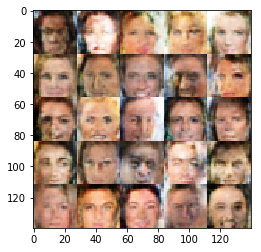

Epoch 1/1... Discriminator Loss: 1.4940... Generator Loss: 0.4056
Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 0.3968
Epoch 1/1... Discriminator Loss: 1.5002... Generator Loss: 0.3752
Epoch 1/1... Discriminator Loss: 1.5025... Generator Loss: 0.3884
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.4860
Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.3922
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.4223
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.4352
Epoch 1/1... Discriminator Loss: 1.5408... Generator Loss: 0.3717
Epoch 1/1... Discriminator Loss: 1.4783... Generator Loss: 0.3876


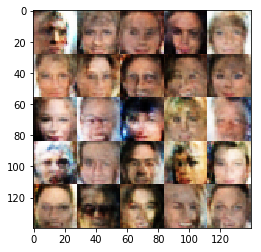

Epoch 1/1... Discriminator Loss: 1.4786... Generator Loss: 0.4174
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.4846
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.4299
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.4401
Epoch 1/1... Discriminator Loss: 1.4918... Generator Loss: 0.3611
Epoch 1/1... Discriminator Loss: 1.4988... Generator Loss: 0.3662
Epoch 1/1... Discriminator Loss: 1.5342... Generator Loss: 0.3662
Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.3981
Epoch 1/1... Discriminator Loss: 1.5240... Generator Loss: 0.3823
Epoch 1/1... Discriminator Loss: 1.4759... Generator Loss: 0.4011


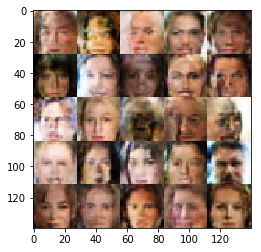

Epoch 1/1... Discriminator Loss: 1.4979... Generator Loss: 0.3749
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.4530
Epoch 1/1... Discriminator Loss: 1.5198... Generator Loss: 0.3557
Epoch 1/1... Discriminator Loss: 1.4986... Generator Loss: 0.3808
Epoch 1/1... Discriminator Loss: 1.4778... Generator Loss: 0.4090
Epoch 1/1... Discriminator Loss: 1.5460... Generator Loss: 0.3721
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.3938
Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.4012
Epoch 1/1... Discriminator Loss: 1.4754... Generator Loss: 0.3881
Epoch 1/1... Discriminator Loss: 1.5178... Generator Loss: 0.3872


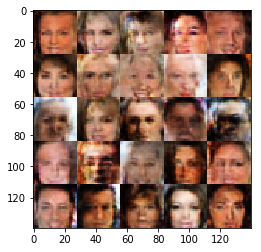

Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.4486
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.3998
Epoch 1/1... Discriminator Loss: 1.5837... Generator Loss: 0.3505
Epoch 1/1... Discriminator Loss: 1.5082... Generator Loss: 0.3750
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.4122
Epoch 1/1... Discriminator Loss: 1.4968... Generator Loss: 0.4012
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.4905
Epoch 1/1... Discriminator Loss: 1.5013... Generator Loss: 0.3927
Epoch 1/1... Discriminator Loss: 1.4730... Generator Loss: 0.3878
Epoch 1/1... Discriminator Loss: 1.5049... Generator Loss: 0.3791


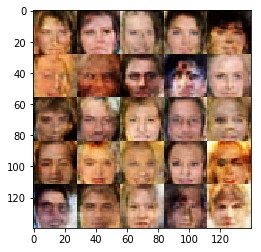

Epoch 1/1... Discriminator Loss: 1.5481... Generator Loss: 0.3663
Epoch 1/1... Discriminator Loss: 1.4773... Generator Loss: 0.3949
Epoch 1/1... Discriminator Loss: 1.4794... Generator Loss: 0.3879
Epoch 1/1... Discriminator Loss: 1.4679... Generator Loss: 0.4258
Epoch 1/1... Discriminator Loss: 1.4792... Generator Loss: 0.4045
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.4213
Epoch 1/1... Discriminator Loss: 1.5361... Generator Loss: 0.3787
Epoch 1/1... Discriminator Loss: 1.5653... Generator Loss: 0.3645
Epoch 1/1... Discriminator Loss: 1.4742... Generator Loss: 0.4010
Epoch 1/1... Discriminator Loss: 1.5011... Generator Loss: 0.3901


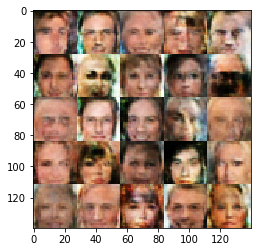

Epoch 1/1... Discriminator Loss: 1.4851... Generator Loss: 0.3810
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.4754
Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.3830
Epoch 1/1... Discriminator Loss: 1.4989... Generator Loss: 0.3877
Epoch 1/1... Discriminator Loss: 1.4780... Generator Loss: 0.4196
Epoch 1/1... Discriminator Loss: 1.4661... Generator Loss: 0.4087
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.4181
Epoch 1/1... Discriminator Loss: 1.4781... Generator Loss: 0.3897
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.3919
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.4340


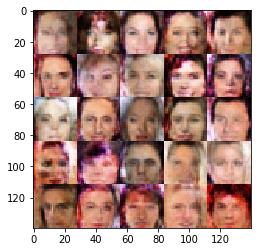

Epoch 1/1... Discriminator Loss: 1.4930... Generator Loss: 0.3938
Epoch 1/1... Discriminator Loss: 1.4987... Generator Loss: 0.3796
Epoch 1/1... Discriminator Loss: 1.5356... Generator Loss: 0.3644
Epoch 1/1... Discriminator Loss: 1.5027... Generator Loss: 0.3991
Epoch 1/1... Discriminator Loss: 1.5229... Generator Loss: 0.3814
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.4496
Epoch 1/1... Discriminator Loss: 1.5441... Generator Loss: 0.3839
Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.3954


In [ ]:
batch_size = 16
z_dim = 100
learning_rate = 0.0001
beta1 = .1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.